In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

2024-12-01 18:13:06.444814: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load data

In [3]:
# File paths
image_dir = '../Downloads/images'
labels_df = pd.read_csv('../Downloads/labels.csv')

# Extract file names and labels
image_filenames = labels_df['Filename'].values
y = labels_df['Label'].values

# Construct full image paths
image_paths = [os.path.join(image_dir, fname) for fname in image_filenames]

# Ensure images and labels are aligned
if len(image_paths) != len(y):
    raise ValueError("Number of images and labels do not match.")

labels_df.head()

,Filename,Label,Species
0,20160928-140314-0.jpg,0,Chinee apple
1,20160928-140337-0.jpg,0,Chinee apple
2,20160928-140731-0.jpg,0,Chinee apple
3,20160928-140747-0.jpg,0,Chinee apple
4,20160928-141107-0.jpg,0,Chinee apple


# Train test split

In [4]:
# Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(image_paths, y, test_size=0.2, stratify=y, random_state=42)

# Create label-to-species mapping for displaying label counts
label_to_species = dict(zip(labels_df['Label'], labels_df['Species']))

# Label distribution
def print_label_distribution(y_train, y_test, label_to_species):
    # Create label counts for train and test datasets
    train_label_counts = pd.Series(y_train).value_counts().reset_index()
    test_label_counts = pd.Series(y_test).value_counts().reset_index()

    # Rename columns
    train_label_counts.columns = ['Label', 'Count']
    test_label_counts.columns = ['Label', 'Count']

    # Map species to the label counts
    train_label_counts['Species'] = train_label_counts['Label'].map(label_to_species)
    test_label_counts['Species'] = test_label_counts['Label'].map(label_to_species)

    # Display the distributions
    print("Training dataset distribution:")
    print(train_label_counts.to_string(index=False))

    print("\nTesting dataset distribution:")
    print(test_label_counts.to_string(index=False))

print_label_distribution(y_train, y_test, label_to_species)

Training dataset distribution:
 Label  Count        Species
     8   7285       Negative
     0    900   Chinee apple
     6    859      Siam weed
     1    851        Lantana
     4    849 Prickly acacia
     2    825    Parkinsonia
     3    818     Parthenium
     7    813     Snake weed
     5    807    Rubber vine

Testing dataset distribution:
 Label  Count        Species
     8   1821       Negative
     0    225   Chinee apple
     6    215      Siam weed
     1    213        Lantana
     4    213 Prickly acacia
     2    206    Parkinsonia
     3    204     Parthenium
     7    203     Snake weed
     5    202    Rubber vine


## Dealing with imbalance data

To mitigate class imbalance, I will randomly select Negative instances (Label is 8) to balance with other classes. 
Undersampling will only be performed on the training set to prevent the model from overfitting to the Negative instances. 

In [5]:
# Function to perform undersampling
def undersample_classes(X_train, y_train, target_size=800):
    # Create DataFrame with image paths and corresponding labels
    train_df = pd.DataFrame({'Filename': X_train, 'Label': y_train})
    
    # Initialize empty list to hold undersampled data
    undersampled_df = []

    # Iterate through each class (label)
    for label in np.unique(y_train):
        # Get the subset of data for this class
        class_subset = train_df[train_df['Label'] == label]
        
        # Sample 'target_size' number of images from each class
        class_sample = class_subset.sample(n=target_size, random_state=42)
        
        # Append the sampled data to the list
        undersampled_df.append(class_sample)
    
    # Combine the undersampled data into one DataFrame
    undersampled_df = pd.concat(undersampled_df, ignore_index=True)
    
    # Return the undersampled image paths and labels
    X_train_balanced = undersampled_df['Filename'].values
    y_train_balanced = undersampled_df['Label'].values
    
    return X_train_balanced, y_train_balanced

# Perform the undersampling
X_train_balanced, y_train_balanced = undersample_classes(X_train, y_train, target_size=800)


In [6]:
# Check the distribution

train_label_counts = pd.Series(y_train_balanced).value_counts().reset_index()

train_label_counts.columns = ['Label', 'Count']

train_label_counts['Species'] = train_label_counts['Label'].map(label_to_species)

print("Training dataset distribution:")
print(train_label_counts)

Training dataset distribution:
   Label  Count         Species
0      0    800    Chinee apple
1      1    800         Lantana
2      2    800     Parkinsonia
3      3    800      Parthenium
4      4    800  Prickly acacia
5      5    800     Rubber vine
6      6    800       Siam weed
7      7    800      Snake weed
8      8    800        Negative


# Pre-processing (resizing, normalization, edge detection)

In [7]:
import tensorflow as tf
import numpy as np
import cv2  # For edge detection

# Function to load and decode images
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Decode as RGB image
    return image

# Preprocess image: resize and normalize
def preprocess_image(image, target_size=(224, 224)):
    image = tf.image.resize(image, target_size)  # Resize image to the target size
    image = image / 255.0  # Normalize to [0, 1]
    return image

# Edge detection using Canny or Sobel
def edge_detection(image):
    # Convert Tensor to NumPy array for edge detection
    image = image.numpy()  # Convert image to NumPy array
    
    # Convert the image to uint8 (necessary for Canny edge detection)
    image = (image * 255).astype(np.uint8)  # Scale back to [0, 255] and cast to uint8
    
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
    edges = cv2.Canny(gray_image, threshold1=100, threshold2=200)  # Apply Canny edge detection
    edges = np.expand_dims(edges, axis=-1)  # Add channel dimension back to make it 3D (HxWx1)
    edges = np.repeat(edges, 3, axis=-1)  # Repeat the edge detection result across all 3 channels (RGB)
    return edges

# Create the dataset for training and testing
def create_dataset(image_paths, labels, batch_size=32, augment=False):
    X_processed = []
    y_processed = []

    for image_path, label in zip(image_paths, labels):
        # Load and preprocess the image
        image = load_image(image_path)
        image = preprocess_image(image)
        
        # Apply edge detection
        image_with_edges = tf.py_function(edge_detection, [image], tf.float32)
        
        # Append processed image and label
        X_processed.append(image_with_edges)
        y_processed.append(label)

    # Convert lists to NumPy arrays for further use
    X_processed = np.array(X_processed)
    y_processed = np.array(y_processed)

    return X_processed, y_processed

X_train_processed, y_train_processed = create_dataset(X_train_balanced, y_train_balanced)
X_test_processed, y_test_processed = create_dataset(X_test, y_test)

# Feature Extraction

### Feature extraction functions

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
from skimage.feature import local_binary_pattern

# Calculate the mean RGB values  
def mean_rgb_array(image):
    return np.mean(image, axis=(0, 1))  # Mean along height and width

# Compute Local Binary Pattern (LBP) features 
def lbp_features(image, radius=1, n_points=8):
    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Compute LBP
    lbp = local_binary_pattern(gray_image, n_points, radius, method="uniform")
    
    # Return the histogram of LBP
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)  # Normalize histogram
    return np.mean(hist) # mean of the LBP histogram 

# Compute the mean value of the Laplacian 
def laplacian_mean_value(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    laplacian = cv2.Laplacian(gray_image, cv2.CV_64F)
    return np.mean(np.abs(laplacian))  # Return mean of absolute Laplacian values

# Compute the mean value of edges in an image using Canny edge detection 
def edge_mean_value(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray_image, threshold1=100, threshold2=200)
    return np.mean(edges)  # Mean edge intensity

# Compute the mean value of Harris corner strengths 
def corner_mean_value(image, block_size=2, ksize=3, k=0.04):
    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray_image = np.float32(gray_image)  # Convert to float32 for cornerHarris

    # Apply Harris corner detection
    corners = cv2.cornerHarris(gray_image, block_size, ksize, k)
    
    # Normalize the corner response to the range [0, 1]
    corners_normalized = cv2.normalize(corners, None, 0, 1, norm_type=cv2.NORM_MINMAX)
    
    # Calculate the mean value of corner strengths
    mean_corner_strength = np.mean(corners_normalized)
    
    return mean_corner_strength

### Apply Feature Extraction Functions

In [9]:
# Extract features for a single image
def extract_features(image):
    # Convert Tensor to NumPy array for processing
    image_np = image.numpy()
    image_np = (image_np * 255).astype(np.uint8)  # Scale to [0, 255]
    
    # Extract features
    features = {
        "rgb_mean": mean_rgb_array(image_np),  # Mean RGB values
        "lbp_mean": lbp_features(image_np),  # Local Binary Pattern histogram
        "laplacian_mean": laplacian_mean_value(image_np),  # Mean Laplacian value
        "edge_mean": edge_mean_value(image_np),  # Mean edge intensity
        "corner_mean": corner_mean_value(image_np),  # Mean corner strength
    }
    return features

# Final Feature Extraction
def extract_features_from_dataset(image_paths):
    feature_list = []
    for image_path in image_paths:
        # Load and preprocess the image
        image = load_image(image_path)
        image = preprocess_image(image)
        
        # Extract features
        features = extract_features(image)
        feature_list.append(features)
    
    return feature_list

### Feature Extraction on Training Data 

In [11]:
train_extracted_features = np.array(extract_features_from_dataset(X_train_balanced))

In [12]:
# Flatten the image data
X_train_flattened = X_train_processed.reshape(X_train_processed.shape[0], -1)

In [13]:
train_features_list = []
for feature in train_extracted_features:
    rgb_mean = feature['rgb_mean']
    lbp_mean = feature['lbp_mean']
    laplacian_mean = feature['laplacian_mean']
    edge_mean = feature['edge_mean']
    corner_mean = feature['corner_mean']
    
    # Flatten the mean_rgb array and concatenate other features into a single list
    features = np.concatenate([rgb_mean, 
                               [lbp_mean, laplacian_mean, edge_mean, corner_mean]])
    train_features_list.append(features)

# Convert the list of features into a numpy array
train_extracted_features_array = np.array(train_features_list)

# Concatenate the image data with the extracted features
X_train_final = np.concatenate([X_train_flattened, train_extracted_features_array], axis=1)
y_train_final = y_train_processed

#### Feature Extraction on Testing Data

In [14]:
test_extracted_features = np.array(extract_features_from_dataset(X_test))

X_test_flattened = X_test_processed.reshape(X_test_processed.shape[0], -1)

test_features_list = []
for feature in test_extracted_features:
    rgb_mean = feature['rgb_mean']
    lbp_mean = feature['lbp_mean']
    laplacian_mean = feature['laplacian_mean']
    edge_mean = feature['edge_mean']
    corner_mean = feature['corner_mean']
    
    # Flatten the mean_rgb array and concatenate other features into a single list
    features = np.concatenate([rgb_mean, 
                               [lbp_mean, laplacian_mean, edge_mean, corner_mean]])
    test_features_list.append(features)

# Convert the list of features into a numpy array
test_extracted_features_array = np.array(test_features_list)

# Concatenate the image data with the extracted features
X_test_final = np.concatenate([X_test_flattened, test_extracted_features_array], axis=1)
y_test_final = y_test_processed

### PCA

In [15]:
from sklearn.decomposition import PCA

apply_PCA = True

if apply_PCA:
    print(f'Original number of features: {X_train_final.shape[1]}')

    pca = PCA(n_components=64, random_state=42)
    X_train_final = pca.fit_transform(X_train_final)
    X_test_final = pca.transform(X_test_final)

    print(f'Reduced number of features after PCA: {X_train_final.shape[1]}')

Original number of features: 150535
Reduced number of features after PCA: 64


### LDA

In [16]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

apply_LDA = True

if apply_LDA:
    print(f'Original number of features: {X_train_final.shape[1]}')

    lda = LinearDiscriminantAnalysis(n_components=8)
    X_train_final = lda.fit_transform(X_train_final, y_train_final)
    X_test_final = lda.transform(X_test_final)

    print(f'Reduced number of features after LDA: {X_train_final.shape[1]}')

Original number of features: 64
Reduced number of features after LDA: 8


## 1. kNN

k-Nearest Neighbors(kNN) is a simple, non-parametric machine learning algorithm commonly used for both classification and regression tasks. It operates based on the principle of similarity, where the outcome for a given data point is influenced by the outcomes of its nearest neighbors in the feature space. 


In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score

k_values = [1, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    knn.fit(X_train_final, y_train_final)
    y_pred_knn = knn.predict(X_test_final)
    f1_knn = f1_score(y_test_final, y_pred_knn, average='micro')
    print(f'kNN micro-averaged f1 score with k={k}: {f1_knn:.4f}')

kNN micro-averaged f1 score with k=1: 0.1676
kNN micro-averaged f1 score with k=50: 0.1967
kNN micro-averaged f1 score with k=100: 0.2050
kNN micro-averaged f1 score with k=150: 0.2099
kNN micro-averaged f1 score with k=200: 0.2107
kNN micro-averaged f1 score with k=250: 0.2210
kNN micro-averaged f1 score with k=300: 0.2202
kNN micro-averaged f1 score with k=350: 0.2167
kNN micro-averaged f1 score with k=400: 0.2213
kNN micro-averaged f1 score with k=450: 0.2204
kNN micro-averaged f1 score with k=500: 0.2179


### Classification Report

In [25]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


# Make kNN predictions with k=13
knn = KNeighborsClassifier(n_neighbors=250, n_jobs=-1)
knn.fit(X_train_final, y_train_final)
y_pred_knn = knn.predict(X_test_final)

# Evaluate using macro-averaged precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(y_test_final, y_pred_knn, average='micro')

# Define the label mapping
target_names = ['Chinese Apple', 'Lantana', 'Parkinsonia', 'Parthenium', 
                'Prickly acacia', 'Rubber vine', 'Siam weed', 'Snake Weed', 'Negatives']

# Output the evaluation metrics
print(f"Micro-averaged Precision: {precision:.2f}")
print(f"Micro-averaged Recall: {recall:.2f}")
print(f"Micro-averaged F1 score: {f1:.2f}")

# Classification Report
print("Classification Report for kNN:")
print(classification_report(y_test_final,y_pred_knn,target_names=target_names))

Micro-averaged Precision: 0.22
Micro-averaged Recall: 0.22
Micro-averaged F1 score: 0.22
Classification Report for kNN:
                precision    recall  f1-score   support

 Chinese Apple       0.31      0.22      0.26       225
       Lantana       0.15      0.13      0.14       213
   Parkinsonia       0.13      0.75      0.22       206
    Parthenium       0.14      0.14      0.14       204
Prickly acacia       0.00      0.00      0.00       213
   Rubber vine       0.13      0.57      0.21       202
     Siam weed       0.25      0.16      0.20       215
    Snake Weed       0.14      0.13      0.13       203
     Negatives       0.66      0.18      0.29      1821

      accuracy                           0.22      3502
     macro avg       0.21      0.25      0.18      3502
  weighted avg       0.42      0.22      0.23      3502



### Confusion Matrix

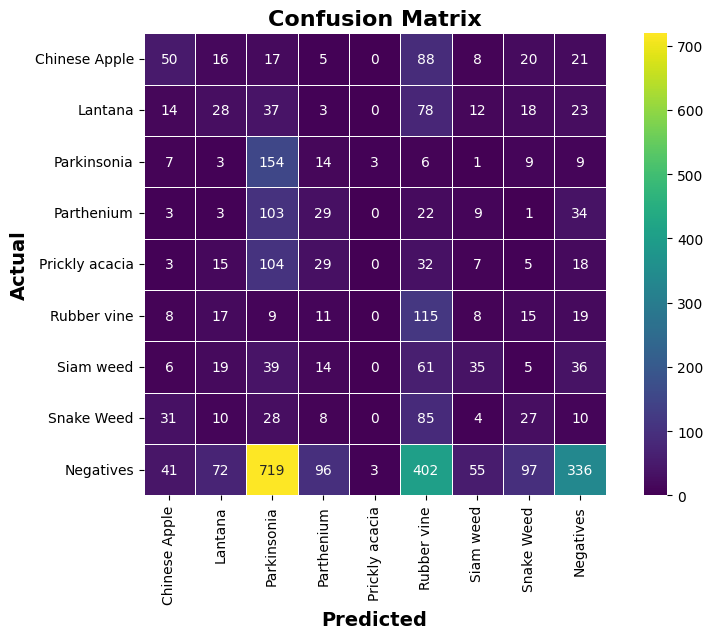

In [26]:
# Generate and print the confusion matrix
conf_matrix = confusion_matrix(y_test_final, y_pred_knn)

plt.figure(figsize=(10, 6))

sns.heatmap(
    conf_matrix, annot=True, fmt='d', cmap='viridis', linewidths=0.4, square=True, cbar=True,
    xticklabels=['Chinese Apple', 'Lantana', 'Parkinsonia', 'Parthenium', 
                'Prickly acacia', 'Rubber vine', 'Siam weed', 'Snake Weed', 'Negatives'],
    yticklabels=['Chinese Apple', 'Lantana', 'Parkinsonia', 'Parthenium', 
                'Prickly acacia', 'Rubber vine', 'Siam weed', 'Snake Weed', 'Negatives']
)

plt.xlabel('Predicted', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=14, fontweight='bold')
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.yticks(rotation=360)

plt.show()

## 2. Random Forest Classifier

Random Forest Classifier is an ensemble learning technique that builds numerous decision trees during training and uses the most common class prediction among the trees for classification tasks. By aggregating predictions from multiple trees, it improves accuracy and resilience in making predictions.

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':[2,10,50],
             'n_estimators':[100, 500,1000]}

# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

clf = GridSearchCV(rf, parameters)
clf.fit(X_train_final, y_train_final)
clf.best_estimator_

RandomForestClassifier(max_depth=10, n_estimators=500, random_state=42)

### Results of GridSearch CV (hyperparameter tuning)

In [34]:
results_df = pd.DataFrame(clf.cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])
results_df = results_df.set_index(
    results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
).rename_axis("kernel")
results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
10_500,"{'max_depth': 10, 'n_estimators': 500}",1,0.288056,0.006325
10_1000,"{'max_depth': 10, 'n_estimators': 1000}",1,0.288056,0.007019
10_100,"{'max_depth': 10, 'n_estimators': 100}",3,0.283056,0.007474
50_1000,"{'max_depth': 50, 'n_estimators': 1000}",4,0.277500,0.009323
50_500,"{'max_depth': 50, 'n_estimators': 500}",5,0.274306,0.007389
50_100,"{'max_depth': 50, 'n_estimators': 100}",6,0.268889,0.005528
2_100,"{'max_depth': 2, 'n_estimators': 100}",7,0.259167,0.004552
2_1000,"{'max_depth': 2, 'n_estimators': 1000}",8,0.255278,0.008943
2_500,"{'max_depth': 2, 'n_estimators': 500}",9,0.254722,0.006386


### Classification Report

In [35]:
# make random forest prediction
rf_model = RandomForestClassifier(max_depth=10, n_estimators=500, random_state=42)
rf_model.fit(X_train_final, y_train_final)
y_pred_rf = rf_model.predict(X_test_final)

# Evaluate using macro-averaged precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(y_test_final, y_pred_rf, average='micro')

# Define the label mapping
target_names = ['Chinese Apple', 'Lantana', 'Parkinsonia', 'Parthenium', 
                'Prickly acacia', 'Rubber vine', 'Siam weed', 'Snake Weed', 'Negatives']

# Output the evaluation metrics
print(f"Micro-averaged Precision: {precision:.2f}")
print(f"Micro-averaged Recall: {recall:.2f}")
print(f"Micro-averaged F1 score: {f1:.2f}")

# Classification Report
print("Classification Report for Random Forest:")
print(classification_report(y_test_final, y_pred_rf, target_names=target_names))

Micro-averaged Precision: 0.20
Micro-averaged Recall: 0.20
Micro-averaged F1 score: 0.20
Classification Report for Random Forest:
                precision    recall  f1-score   support

 Chinese Apple       0.26      0.29      0.27       225
       Lantana       0.15      0.15      0.15       213
   Parkinsonia       0.16      0.72      0.26       206
    Parthenium       0.11      0.18      0.14       204
Prickly acacia       0.18      0.03      0.05       213
   Rubber vine       0.11      0.48      0.18       202
     Siam weed       0.22      0.24      0.23       215
    Snake Weed       0.15      0.22      0.17       203
     Negatives       0.66      0.12      0.21      1821

      accuracy                           0.20      3502
     macro avg       0.22      0.27      0.18      3502
  weighted avg       0.43      0.20      0.20      3502



### Confusion Matrix

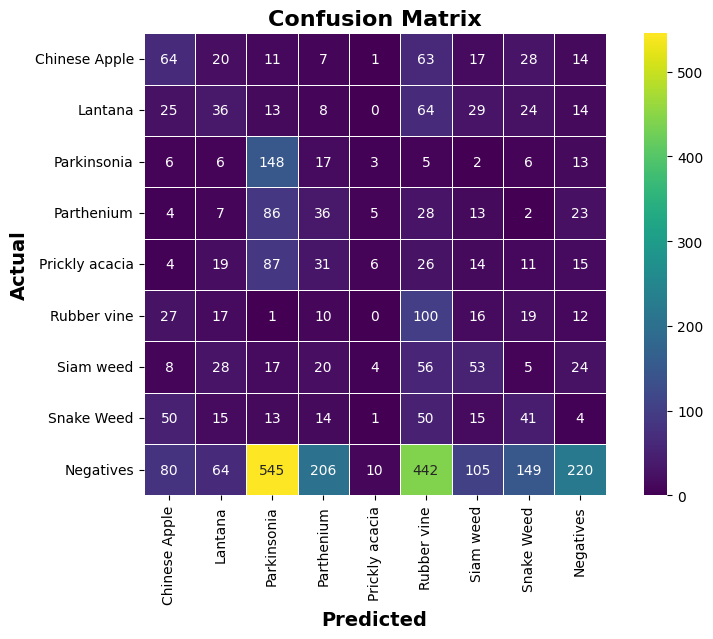

In [30]:
# Generate and print the confusion matrix
conf_matrix = confusion_matrix(y_test_final, y_pred_rf)

plt.figure(figsize=(10, 6))

sns.heatmap(
    conf_matrix, annot=True, fmt='d', cmap='viridis', linewidths=0.4, square=True, cbar=True,
    xticklabels=['Chinese Apple', 'Lantana', 'Parkinsonia', 'Parthenium', 
                'Prickly acacia', 'Rubber vine', 'Siam weed', 'Snake Weed', 'Negatives'],
    yticklabels=['Chinese Apple', 'Lantana', 'Parkinsonia', 'Parthenium', 
                'Prickly acacia', 'Rubber vine', 'Siam weed', 'Snake Weed', 'Negatives']
)

plt.xlabel('Predicted', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=14, fontweight='bold')
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.yticks(rotation=360)

plt.show()

## 3. SVM

A Support Vector Machine (SVM) is a supervised machine learning algorithm widely used for classification and regression tasks. SVMs are particularly effective in high-dimensional spaces and for problems where the decision boundary between classes is complex.

In [ ]:
from sklearn import svm
from sklearn.metrics import f1_score

param_grid = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'gamma': [1, 0.1, 0.01]  # Kernel coefficient
}

# Store results
best_f1 = 0
best_params = {}

# Iterate over the parameter grid
for C in param_grid['C']:
    for gamma in param_grid['gamma']:
        # Train the SVM model with the current parameters
        svc = svm.SVC(kernel='rbf', C=C, gamma=gamma)
        svc.fit(X_train_final, y_train_final)
        
        # Predict on the test set
        y_pred_svm = svc.predict(X_test_final)
        
        # Calculate the F1 score with appropriate averaging for multiclass
        f1 = f1_score(y_test_final, y_pred_svm, average='micro')
        print(f"Parameters: C={C}, gamma={gamma}, F1 score={f1:.4f}")
        
        # Update the best model if current F1 score is better
        if f1 > best_f1:
            best_f1 = f1
            best_params = {'C': C, 'gamma': gamma}

# Output the best parameters and corresponding F1 score
print("\nBest Parameters:", best_params)
print("Best F1 Score:", best_f1)


Parameters: C=0.1, gamma=1, F1 score=0.2130
Parameters: C=0.1, gamma=0.1, F1 score=0.2490
Parameters: C=0.1, gamma=0.01, F1 score=0.1850
Parameters: C=1, gamma=1, F1 score=0.2230
Parameters: C=1, gamma=0.1, F1 score=0.2610
Parameters: C=1, gamma=0.01, F1 score=0.2487
Parameters: C=10, gamma=1, F1 score=0.1868
Parameters: C=10, gamma=0.1, F1 score=0.2387
Parameters: C=10, gamma=0.01, F1 score=0.2641

Best Parameters: {'C': 10, 'gamma': 0.01}
Best F1 Score: 0.2641347801256425


### Classification Report

In [40]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Make svm prediction
from sklearn import svm
svc_rbf = svm.SVC(kernel='rbf', C=10, gamma=0.01)
svc_rbf.fit(X_train_final, y_train_final)
y_pred_svm = svc_rbf.predict(X_test_final)

# Evaluate using macro-averaged precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(y_test_final, y_pred_svm, average='micro')

# Define the label mapping
target_names = ['Chinese Apple', 'Lantana', 'Parkinsonia', 'Parthenium', 
                'Prickly acacia', 'Rubber vine', 'Siam weed', 'Snake Weed', 'Negatives']

# Output the evaluation metrics
print(f"Micro-averaged Precision: {precision:.2f}")
print(f"Micro-averaged Recall: {recall:.2f}")
print(f"Micro-averaged F1 score: {f1:.2f}")

# Classification Report
print("Classification Report for SVM:")
print(classification_report(y_test_final,y_pred_svm,target_names=target_names))

Micro-averaged Precision: 0.26
Micro-averaged Recall: 0.26
Micro-averaged F1 score: 0.26
Classification Report for SVM:
                precision    recall  f1-score   support

 Chinese Apple       0.25      0.26      0.25       225
       Lantana       0.18      0.19      0.19       213
   Parkinsonia       0.17      0.68      0.27       206
    Parthenium       0.17      0.11      0.14       204
Prickly acacia       0.19      0.03      0.05       213
   Rubber vine       0.14      0.55      0.23       202
     Siam weed       0.18      0.33      0.23       215
    Snake Weed       0.13      0.12      0.12       203
     Negatives       0.68      0.25      0.36      1821

      accuracy                           0.26      3502
     macro avg       0.23      0.28      0.20      3502
  weighted avg       0.44      0.26      0.28      3502



### Confusion Matrix

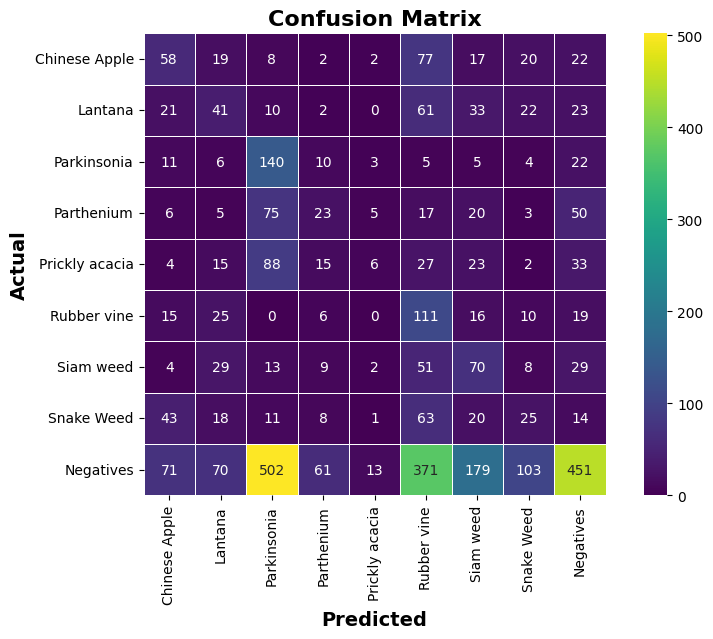

In [ ]:
# Generate and print the confusion matrix
conf_matrix = confusion_matrix(y_test_final, y_pred_svm)

plt.figure(figsize=(10, 6))

sns.heatmap(
    conf_matrix, annot=True, fmt='d', cmap='viridis', linewidths=0.4, square=True, cbar=True,
    xticklabels=['Chinese Apple', 'Lantana', 'Parkinsonia', 'Parthenium', 
                'Prickly acacia', 'Rubber vine', 'Siam weed', 'Snake Weed', 'Negatives'],
    yticklabels=['Chinese Apple', 'Lantana', 'Parkinsonia', 'Parthenium', 
                'Prickly acacia', 'Rubber vine', 'Siam weed', 'Snake Weed', 'Negatives']
)

plt.xlabel('Predicted', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=14, fontweight='bold')
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.yticks(rotation=360)

plt.show()